# Creating a valid recommendation set

The valid recommendation set will have a length of 15 and will be composed of:
* Most recent true reviews with a score or 4 or 5
* also_buy column whenever needed to complement the set, following these criteria:
    * The most recent also_buy will be considered first
    * The top items from that list will be used to complement
    * Should that list be empty / not long enough, the preceding also_buy will be used

For example:
* For a user with 20 reviews of 4 and 5, the 15 most recent will be taken into account
* For a user with 5 reviews of 4 and 5, all will be taken into account, plus 10 taken from also_buy

## Importing Libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.utils import shuffle

## Reading the data

In [2]:
# Read data
train_df = pd.read_pickle("../../train_df_2.pkl")
test_df = pd.read_pickle("../../test_df_2.pkl")

In [3]:
# Exploring shapes of resulting dataframes
print(train_df.shape)
print(test_df.shape)

(206085, 20)
(84554, 20)


In [4]:
# Create Train/Test flag
train_df["Set"] = "Train"
test_df["Set"] = "Test"

In [5]:
# Merge data for initial investigation
data = pd.concat([train_df, test_df], sort = False)

In [6]:
# Explore dataset
print(data.shape)
data.head(2)

(290639, 21)


,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,...,title,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews,Set
473590,473590,5,False,2016-07-16,A2KJVIU82ZUSBA,B0186D1UQ0,Fantastic,Best Remake I've Ever Played,0,{'Format:': ' Video Game'},...,Odin Sphere Leifthrasir - PlayStation 4 Standa...,by Atlus,">#4,665 in Video Games (See Top 100 in Video G...",Video Games,"[""ATLUS x Vanillaware, the team behind the hit...","['B077Y7313L', 'B0794Y8FLW', 'B01HQGWBZ2', 'B0...","['B077Y7313L', 'B0794Y8FLW', 'B017GY06UQ', 'B0...","['HD Art Upgrade: Known for its beautiful, 2D ...",26,Train
128446,128446,5,True,2014-07-18,A3GENOZU8QJZAZ,B000R39GPA,Great game,PS3,0,"{'Edition:': ' Standard', 'Platform:': ' PlayS...",...,Star Wars: The Force Unleashed,by LucasArts,">#9,056 in Video Games (See Top 100 in Video G...",Video Games,['The Star Wars saga will continue in Star War...,"['B0030F1DOO', 'B003FMUMBM', 'B00EY3F8LU', 'B0...","['B01BCMBP44', 'B0030F1DOO', 'B00EY3F8LU', 'B0...",['Confront and associate with familiar faces f...,140,Train


## Exploring count of reviews per user

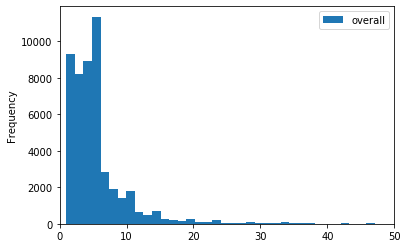

In [7]:
pd.DataFrame(data.groupby(["reviewerID"]).count()["overall"]).plot.hist(bins = 500)
plt.xlim((0, 50))
plt.show()

## Exploring count of 4 and 5 star reviews per user

In [32]:
pd.DataFrame(data[data.overall.isin([4, 5])].groupby(["reviewerID"]).count()["reviewID"]).sort_values(by = "reviewID")

,reviewID
reviewerID,
AZZTOUKVTUMVM,1
A38VJPJCLMZ2XR,1
A38VWX46A6PJ51,1
A38W304R7UYCQ8,1
A1JA5QY189OUMS,1
...,...
A2TCG2HV1VJP6V,231
A29BQ6B90Y1R5F,258
A119Q9NFGVOEJZ,269


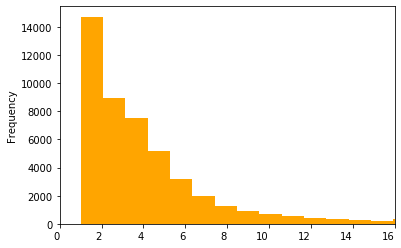

In [33]:
pd.DataFrame(data[data.overall.isin([4, 5])].groupby(["reviewerID"]).count()["overall"]).plot.hist(bins = 500, color = "orange", legend = False)
plt.xlim((0, 16))
plt.xticks(horizontalalignment = "right")
plt.show()

## Exploring how to create a valid recommendation set per user

### Extracting only positive (4 or 5) reviews for each user

In [8]:
# Filter 4 and 5 reviews, order by reviewer, rating, and reviewtime in descending order
positive_reviews = data[(data["overall"] == 4) | (data["overall"] == 5)].sort_values(by = ["reviewerID", "overall", "reviewTime"], axis = 0, ascending = False)[["reviewID", "overall", "reviewTime", "reviewerID", "productID"]]

In [9]:
# Check only 4 and 5 remain
positive_reviews["overall"].unique()

array([5, 4])

In [10]:
# Explore dataset
positive_reviews.head(10)

,reviewID,overall,reviewTime,reviewerID,productID
334469,334469,5,2014-10-27,AZZTOUKVTUMVM,B00BU3ZLJQ
262057,262057,4,2013-04-13,AZZTC2OYVNE2Q,B004PAGJOC
279005,279005,4,2012-12-27,AZZTC2OYVNE2Q,B0050SYX8W
388123,388123,5,2016-09-14,AZZT1ERHBSNQ8,B00IXMF5CU
406708,406708,5,2016-09-14,AZZT1ERHBSNQ8,B00KWFCV32
334515,334515,5,2014-07-08,AZZT1ERHBSNQ8,B00BU3ZLJQ
128182,128182,5,2009-02-08,AZZKH219IDQGY,B000R2WIE2
126401,126401,4,2009-08-21,AZZKH219IDQGY,B000QB058U
55869,55869,4,2009-02-08,AZZKH219IDQGY,B00009ECGH
407261,407261,5,2015-09-17,AZZHLZ8H23QD4,B00KWFCSB2


In [11]:
# Create dictionary with top 15 (if possible) reviews for each reviewer
positive_dict = dict()
# Loop over each row, adding reviewers and their preferences
for index, row in positive_reviews.iterrows():
    
    if row["reviewerID"] not in positive_dict.keys():
        positive_dict[row["reviewerID"]] = [row["productID"]]
    
    elif len(positive_dict[row["reviewerID"]]) < 15:
        positive_dict[row["reviewerID"]].append(row["productID"])

In [12]:
# Check the dictionary was well constructed
len(positive_dict.keys()) == len(positive_reviews["reviewerID"].unique())

True

In [13]:
# Explore an example
positive_dict["AZZT1ERHBSNQ8"]

['B00IXMF5CU', 'B00KWFCV32', 'B00BU3ZLJQ']

### Extracting top 15 products from also_buy

In [14]:
# Order reviews by reviewerID and date in decending order
ordered_data = data.sort_values(by = ["reviewerID", "reviewTime"], axis = 0, ascending = False)
ordered_data = ordered_data[["reviewID", "overall", "reviewTime", "reviewerID", "productID", "also_buy"]]

In [15]:
# Drop rows with no recommendation
ordered_data.dropna(axis = 0, subset = ["also_buy"], inplace = True)

In [16]:
# Convert also_buy string to list
ordered_data["amz_recommendation"] = ordered_data["also_buy"].apply(lambda x: ast.literal_eval(x))

In [17]:
# Drop also_buy
ordered_data.drop(["also_buy"], axis = 1, inplace = True)

In [18]:
# Explore ordered data
ordered_data.head(10)

,reviewID,overall,reviewTime,reviewerID,productID,amz_recommendation
334469,334469,5,2014-10-27,AZZTOUKVTUMVM,B00BU3ZLJQ,"[B00SXEOOHU, B00B98HF1O, B001G3AZS2, B004X56OU..."
262057,262057,4,2013-04-13,AZZTC2OYVNE2Q,B004PAGJOC,"[B00CP1UQPG, B002I098JE, B00A7QPNK4, B009JBFG0..."
279005,279005,4,2012-12-27,AZZTC2OYVNE2Q,B0050SYX8W,"[B000FRU0NU, B001HWB68K, B002BSA20M, B0050SYY5..."
209106,209106,3,2012-12-27,AZZTC2OYVNE2Q,B001PB9J14,"[B0017ZDGWG, B006ZTHGCK, B003O6G6RI, B000ZKDOV..."
388123,388123,5,2016-09-14,AZZT1ERHBSNQ8,B00IXMF5CU,"[B00BYDKCZK, B0050SYAQ2, B00CKKIJ24, B002I0J9M..."
406708,406708,5,2016-09-14,AZZT1ERHBSNQ8,B00KWFCV32,"[B00DD0B0BM, B01AC3ZD2O, B01AC3ZD06, B00D41GCV..."
334515,334515,5,2014-07-08,AZZT1ERHBSNQ8,B00BU3ZLJQ,"[B00SXEOOHU, B00B98HF1O, B001G3AZS2, B004X56OU..."
126401,126401,4,2009-08-21,AZZKH219IDQGY,B000QB058U,[076155355X]
195393,195393,1,2009-08-21,AZZKH219IDQGY,B001C6Q8QG,"[B00CCT483M, B0058NY622, B005OGYVKU, B002V1GFH..."
128182,128182,5,2009-02-08,AZZKH219IDQGY,B000R2WIE2,"[B001E3ARJ6, B000B8P8RG, B000E0XX9Q, B000E0TOK..."


In [19]:
# Create dictionary with top 15 (if possible) products from also_buy, starting with the most recent recommendations
also_buy_dict = dict()
# Loop over each row, adding reviewers and their recommended products
for index, row in ordered_data.iterrows():
   
    # Add new key
    if row["reviewerID"] not in also_buy_dict.keys():
        
        # If the recommendation list is too long add only the first 15, else add all
        if len(row["amz_recommendation"]) >= 15:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"][:15]
        else:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"]
    
    # Update value for the given key, to complete the length of 15 products
    elif len(also_buy_dict[row["reviewerID"]]) < 15:
        
        # Define how many elements to add to the list
        x = 15 - len(also_buy_dict[row["reviewerID"]])
        
        # Add as many elements as possible and required
        if len(row["amz_recommendation"]) >= x:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"][:x])
        else:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"])
            

In [20]:
# Check the dictionary was well constructed
len(also_buy_dict.keys()) == len(ordered_data["reviewerID"].unique())

True

In [21]:
# Check all keys have at most 15 items
pd.DataFrame(also_buy_dict.values())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B00SXEOOHU,B00B98HF1O,B001G3AZS2,B004X56OU8,B00ECOBFA4,B014XCWZA8,B01LZVTM35,B00T57U7V6,B002BS4JDS,B002BRYHUY,B00EFL2R2O,B073VY4P31,B076HGRQGK,B008OQTRYW,B005YR1VP2
1,B00CP1UQPG,B002I098JE,B00A7QPNK4,B009JBFG00,B0050SYV70,B00MU1YENG,B000UU3SVI,B000F3AADE,B002EE5ROO,B00EFFW0HC,B000ZK6950,B000FRS9II,B003JVKHEQ,B00CJ7IUGS,B01C7L07OI
2,B00BYDKCZK,B0050SYAQ2,B00CKKIJ24,B002I0J9M0,B004X56OU8,0399541330,B002BRYHUY,B001G3AZS2,B076HGRQGK,B00B98HF1O,B000WMEEAI,B014XCWZA8,B00MEXP5KG,B0017ZDGWG,B00ECOBFA4
3,076155355X,B00CCT483M,B0058NY622,B005OGYVKU,B002V1GFHS,B003BU77P2,B000WCCURW,B004BYDPJO,B0044S8DA8,B000FGA1US,B005AUXYYY,B001Q96ZNU,B001E2I4H4,0979551307,B004WMTOWC
4,B012F20ZY6,B00DC7G0GG,B00KWF366S,B009AGXH64,B01AC3ZD06,B00DC7G2W8,B00KWG4HG0,B00DD0B0BM,B01CKGI4RM,B00G0OYHCW,B00DC7O77A,B00MUY0OFU,B00TV90AGA,B00LCHZRIK,B00NJ0HTH0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49453,B00ZMBMO06,B00M31VIOG,B01GW90BTW,B00CMQTTZ2,B01AVGIGZI,B01CDK2Z48,B0787NN56S,B01EJNUMQ0,B07MC9GTH5,B07542DJQY,B00ZMBLKPG,B079ZPD1BV,B00ZPTMX60,B00NY62FH8,B01N0OK8XH
49454,B01EZA0D8O,B00CX6XKK6,B01EUPD3VS,B00MU1YEE0,B00UL908IY,B07859CC47,B072NQJCW5,B0166QDJZE,B01EZA0DEI,B071JRHDFQ,B00KVSQAGO,B07D4WR5XJ,B01GKF824Y,B00D781W3Q,B00KL3W626
49455,B000058BCU,B000031KJM,B000046S41,B00002DHEV,B00002STEZ,B00000J2W7,B00000DMAX,B00000F1GM,B00002STH0,B00000DMB3,B00P1OYN0S,B00000ID61,B00002STFH,B0012YLDHC,B00000DMAQ
49456,B0007W5IUS,B0009UBR3A,B00006IJJK,B000066JRN,B0002ILS1K,B00009WAUD,B01LWA474D,B00006IJJI,B011HMIVJ6,B00005Q8M0,B00CHRNOPW,B0009XSMNA,B0000A2Y96,B00005Q8LR,B00006FWTX


### Creating the final recommendation set (merging positive reviews with also_buy)

In [22]:
# Create list of unique users for easier iteration
unique_users = data["reviewerID"].unique()
print(len(unique_users))

49666


In [23]:
# Investigate lengths of dictionaries
print(len(positive_dict))
print(len(also_buy_dict))

47716
49458


In [24]:
# Create final recommendation set dictionary
rec_dict = dict()

# Iterate through each user
for user in unique_users:
    
    # Check if user has positive reviews and keep them
    if user in positive_dict.keys():
        rec_dict[user] = positive_dict[user]
    
    # Check if user can be completed by also_buy
    if user in also_buy_dict.keys():
        
        # Check if it needs to be completed
        if user in rec_dict.keys() and len(rec_dict[user]) < 15:
            
            # Check how many items are missing
            x = 15 - len(rec_dict[user])
            
            # Check if also_buy has enough products to complete
            if len(also_buy_dict[user]) >= x:
            
                # Complete list with exact number of products from also_buy
                rec_dict[user].extend(also_buy_dict[user][:x])
            
            else:
                
                # Complete with as many products as it has
                rec_dict[user].extend(also_buy_dict[user])
        
        # Chech if the user needs to be started from scratch bc it didnt have positive reviews
        if user not in rec_dict.keys():
            rec_dict[user] = also_buy_dict[user]
        
        

In [25]:
# Check how long the new dict should be (union of both positive and also_buy)
len(set(positive_dict.keys()).union(set(also_buy_dict.keys())))

49620

In [26]:
# Check length of new dictionary
len(rec_dict)

49620

In [27]:
# Investigate users not present in any set
investigate = list()
for user in unique_users:
    if user not in rec_dict.keys():
        investigate.append(user)

In [28]:
# How many users dont have any kind of recommendation
len(investigate)

46

In [29]:
investigate[:5]

['A78PJ50UNRJV6',
 'A38EDDASAM1W0V',
 'ADRMIAHG306RV',
 'A12ESGQ81M70JX',
 'A1TDT6YBRP7DPC']

In [30]:
# Example
data[data["reviewerID"] == "A78PJ50UNRJV6"]

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,...,title,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews,Set
343803,343803,1,False,2014-05-02,A78PJ50UNRJV6,B00CX6G1IE,I bought this and activated it on my Origin ac...,This is a cheat pack that ruins the game,2,NaN,...,Burnout Paradise Bonus Vehicle Pack [Online Ga...,by Electronic Arts,">#36,569 in Video Games (See Top 100 in Video ...",Video Games,"['', 'Burnout Paradise Bonus Vehicle Pack', 'G...",NaN,NaN,['Requires Origin Client to activate. The DLC ...,12,Train
309449,309449,1,False,2012-12-17,A78PJ50UNRJV6,B007XWHO98,This is the most unpleasant game to look at I'...,Graphics make me physically ill,4,NaN,...,Stacking [Download],by Double Fine Productions,NaN,Video Games,"['', 'From Tim Schafer’s Double Fine Productio...",NaN,['B00803MX90'],['You can download your game or software order...,6,Train


In [31]:
# Example
data[data["reviewerID"] == "A38EDDASAM1W0V"]

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,...,title,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews,Set
63498,63498,1,False,2004-06-20,A38EDDASAM1W0V,B00013MRU2,"I really, really wish that I had read some rev...",not at all what I expected...,39,NaN,...,A Quiet Weekend In Capri - PC,by Got Game,">#81,925 in Video Games (See Top 100 in Video ...",Video Games,['GOT GAME A Quiet Weekend in Capri - As a tou...,NaN,NaN,"['Graphical mystery adventure', 'First person'...",9,Train
43905,43905,3,False,2003-05-29,A38EDDASAM1W0V,B00006AALC,This game follows the adventures of Kate Walke...,Syberia,27,{'Platform:': ' PC'},...,Syberia - PC,by Dreamcatcher Interactive,">#44,775 in Video Games (See Top 100 in Video ...",Video Games,"['Kate Walker, a corporate lawyer from the USA...",NaN,"['B0017HLYNC', 'B000BNB2GW', 'B06WWRR72F', 'B0...","[""You play as Kate Walker, a businesswoman loo...",64,Train


In [32]:
# Example
data[data["reviewerID"] == "A1TDT6YBRP7DPC"]

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,...,title,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews,Set
373416,373416,1,True,2013-03-27,A1TDT6YBRP7DPC,B00GGUUUQW,"This is an insult to anything branded, ""The Wa...",Rubbish!!!!!,5,{'Platform:': ' PlayStation 3'},...,The Walking Dead Survival Instinct - PS3 [Dig...,by Activision,NaN,Video Games,"['', 'The Walking Dead video game takes the un...",NaN,NaN,['First-person action game based on the Emmy a...,88,Train


In [33]:
# How many rows are affected
len(data[data["reviewerID"].isin(investigate)])

56

In [34]:
# How many from Train, and how many from Test
data[data["reviewerID"].isin(investigate)]["Set"].value_counts()

Train    54
Test      2
Name: Set, dtype: int64

We should remove rows without enough information

## Creating a Valid Recommendation set for Train

In [35]:
# Filter 4 and 5 reviews, order by reviewer, rating, and reviewtime in descending order
positive_reviews = train_df[(train_df["overall"] == 4) | (train_df["overall"] == 5)].sort_values(by = ["reviewerID", "overall", "reviewTime"], axis = 0, ascending = False)[["reviewID", "overall", "reviewTime", "reviewerID", "productID"]]

# Create dictionary with top 15 (if possible) reviews for each reviewer
positive_dict = dict()
# Loop over each row, adding reviewers and their preferences
for index, row in positive_reviews.iterrows():
    if row["reviewerID"] not in positive_dict.keys():
        positive_dict[row["reviewerID"]] = [row["productID"]]
    elif len(positive_dict[row["reviewerID"]]) < 15:
        positive_dict[row["reviewerID"]].append(row["productID"])

# Order reviews by reviewerID and date in decending order
ordered_data = train_df.sort_values(by = ["reviewerID", "reviewTime"], axis = 0, ascending = False)
ordered_data = ordered_data[["reviewID", "overall", "reviewTime", "reviewerID", "productID", "also_buy"]]

# Drop rows with no recommendation
ordered_data.dropna(axis = 0, subset = ["also_buy"], inplace = True)

# Convert also_buy string to list
ordered_data["amz_recommendation"] = ordered_data["also_buy"].apply(lambda x: ast.literal_eval(x))

# Drop also_buy
ordered_data.drop(["also_buy"], axis = 1, inplace = True)

# Create dictionary with top 15 (if possible) products from also_buy, starting with the most recent recommendations
also_buy_dict = dict()
# Loop over each row, adding reviewers and their recommended products
for index, row in ordered_data.iterrows():
   
    # Add new key
    if row["reviewerID"] not in also_buy_dict.keys():
        
        # If the recommendation list is too long add only the first 15, else add all
        if len(row["amz_recommendation"]) >= 15:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"][:15]
        else:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"]
    
    # Update value for the given key, to complete the length of 15 products
    elif len(also_buy_dict[row["reviewerID"]]) < 15:
        
        # Define how many elements to add to the list
        x = 15 - len(also_buy_dict[row["reviewerID"]])
        
        # Add as many elements as possible and required
        if len(row["amz_recommendation"]) >= x:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"][:x])
        else:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"])

# Create list of unique users for easier iteration
unique_users = train_df["reviewerID"].unique()

# Create final recommendation set dictionary
rec_dict = dict()

# Iterate through each user
for user in unique_users:
    
    # Check if user has positive reviews and keep them
    if user in positive_dict.keys():
        rec_dict[user] = positive_dict[user]
    
    # Check if user can be completed by also_buy
    if user in also_buy_dict.keys():
        
        # Check if it needs to be completed
        if user in rec_dict.keys() and len(rec_dict[user]) < 15:
            
            # Check how many items are missing
            x = 15 - len(rec_dict[user])
            
            # Check if also_buy has enough products to complete
            if len(also_buy_dict[user]) >= x:
            
                # Complete list with exact number of products from also_buy
                rec_dict[user].extend(also_buy_dict[user][:x])
            
            else:
                
                # Complete with as many products as it has
                rec_dict[user].extend(also_buy_dict[user])
        
        # Chech if the user needs to be started from scratch bc it didnt have positive reviews
        if user not in rec_dict.keys():
            rec_dict[user] = also_buy_dict[user]



In [36]:
# Rename dictionary
train_recommendation_dict = rec_dict

In [37]:
# Save recommendation set to dataframe
train_df["valid_recommendations"] = train_df["reviewerID"].map(train_recommendation_dict)

In [38]:
# Explore how many rows don't have 15 recommendations
remove_reviews = list()
for index, row in train_df.iterrows():
    if type(row["valid_recommendations"]) == float:
        remove_reviews.append(row["reviewID"])
    elif len(row["valid_recommendations"]) < 15:
        remove_reviews.append(row["reviewID"])

In [39]:
# Count of rows without enough reviews
len(remove_reviews)

3095

In [40]:
# Total length in Train
len(train_df)

206085

In [41]:
# Drop rows without enough reviews
train_df.drop(index = remove_reviews, inplace = True)

In [42]:
# New length in Train
len(train_df)

202990

## Splitting Test into 2: Validation and Test

In [43]:
validation_ratio = 0.67
shuffled_data = shuffle(test_df, random_state = 232323)
split_cut = np.int(np.round(len(shuffled_data) * validation_ratio))

In [44]:
# Split the data
validation_df = shuffled_data.iloc[0:split_cut]
test_df = shuffled_data.iloc[split_cut::]

In [45]:
# Check resulting shapes
print(validation_df.shape)
print(test_df.shape)

(56651, 21)
(27903, 21)


In [46]:
print(train_df.shape)

(202990, 22)


## Creating a valid recommendation set for Validation

In [47]:
# Use both Train and Validation history for this
data_train_val = pd.concat([train_df, validation_df], sort = False)

In [48]:
# Filter 4 and 5 reviews, order by reviewer, rating, and reviewtime in descending order
positive_reviews = data_train_val[(data_train_val["overall"] == 4) | (data_train_val["overall"] == 5)].sort_values(by = ["reviewerID", "overall", "reviewTime"], axis = 0, ascending = False)[["reviewID", "overall", "reviewTime", "reviewerID", "productID"]]

# Create dictionary with top 15 (if possible) reviews for each reviewer
positive_dict = dict()

# Loop over each row, adding reviewers and their preferences
for index, row in positive_reviews.iterrows():
    if row["reviewerID"] not in positive_dict.keys():
        positive_dict[row["reviewerID"]] = [row["productID"]]
    
    elif len(positive_dict[row["reviewerID"]]) < 15:
        positive_dict[row["reviewerID"]].append(row["productID"])

# Order reviews by reviewerID and date in decending order
ordered_data = data_train_val.sort_values(by = ["reviewerID", "reviewTime"], axis = 0, ascending = False)
ordered_data = ordered_data[["reviewID", "overall", "reviewTime", "reviewerID", "productID", "also_buy"]]

# Drop rows with no recommendation
ordered_data.dropna(axis = 0, subset = ["also_buy"], inplace = True)

# Convert also_buy string to list
ordered_data["amz_recommendation"] = ordered_data["also_buy"].apply(lambda x: ast.literal_eval(x))

# Drop also_buy
ordered_data.drop(["also_buy"], axis = 1, inplace = True)

# Create dictionary with top 15 (if possible) products from also_buy, starting with the most recent recommendations
also_buy_dict = dict()

# Loop over each row, adding reviewers and their recommended products
for index, row in ordered_data.iterrows():
   
    # Add new key
    if row["reviewerID"] not in also_buy_dict.keys():
        
        # If the recommendation list is too long add only the first 15, else add all
        if len(row["amz_recommendation"]) >= 15:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"][:15]
        else:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"]
    
    # Update value for the given key, to complete the length of 15 products
    elif len(also_buy_dict[row["reviewerID"]]) < 15:
        
        # Define how many elements to add to the list
        x = 15 - len(also_buy_dict[row["reviewerID"]])
        
        # Add as many elements as possible and required
        if len(row["amz_recommendation"]) >= x:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"][:x])
        else:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"])

# Create list of unique users for easier iteration
unique_users = data_train_val["reviewerID"].unique()

# Create final recommendation set dictionary
rec_dict = dict()

# Iterate through each user
for user in unique_users:
    
    # Check if user has positive reviews and keep them
    if user in positive_dict.keys():
        rec_dict[user] = positive_dict[user]
    
    # Check if user can be completed by also_buy
    if user in also_buy_dict.keys():
        
        # Check if it needs to be completed
        if user in rec_dict.keys() and len(rec_dict[user]) < 15:
            
            # Check how many items are missing
            x = 15 - len(rec_dict[user])
            
            # Check if also_buy has enough products to complete
            if len(also_buy_dict[user]) >= x:
            
                # Complete list with exact number of products from also_buy
                rec_dict[user].extend(also_buy_dict[user][:x])
            
            else:
                
                # Complete with as many products as it has
                rec_dict[user].extend(also_buy_dict[user])
        
        # Chech if the user needs to be started from scratch bc it didnt have positive reviews
        if user not in rec_dict.keys():
            rec_dict[user] = also_buy_dict[user]



In [49]:
# Rename dictionary
validation_recommendation_dict = rec_dict

In [50]:
# Save recommendation set to dataframe
validation_df["valid_recommendations"] = validation_df["reviewerID"].map(validation_recommendation_dict)

/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
# Explore how many rows don't have 15 recommendations
remove_reviews = list()

for index, row in validation_df.iterrows():
    
    if type(row["valid_recommendations"]) == float:
        remove_reviews.append(row["reviewID"])
    
    elif len(row["valid_recommendations"]) < 15:
        remove_reviews.append(row["reviewID"])

In [52]:
# Count of rows without enough reviews
len(remove_reviews)

455

In [53]:
# Drop rows without enough reviews
validation_df.drop(index = remove_reviews, inplace = True)

/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [54]:
# Count products and items not in Train
len(validation_df)-len(validation_df[(validation_df['reviewerID'].isin(train_df['reviewerID'])) 
        & (validation_df['productID'].isin(train_df['productID']))])

1050

In [55]:
# For Validation set, keep only rows with products and users present in Train set
validation_df = validation_df[(validation_df['reviewerID'].isin(train_df['reviewerID'])) 
        & (validation_df['productID'].isin(train_df['productID']))]

In [56]:
len(validation_df)

55146

In [57]:
# All reviewers from Test contained in Train?
sum(validation_df["reviewerID"].isin(train_df["reviewerID"].unique())) == len(validation_df)

True

In [58]:
# All products from Test contained in Train?
sum(validation_df["productID"].isin(train_df["productID"].unique())) == len(validation_df)

True

## Creating a valid recommendation set for Test

In [59]:
# Use Train, Validation and Test history for this
data_train_val_test = pd.concat([train_df, validation_df, test_df], sort = False)

In [60]:
# Filter 4 and 5 reviews, order by reviewer, rating, and reviewtime in descending order
positive_reviews = data_train_val_test[(data_train_val_test["overall"] == 4) | (data_train_val_test["overall"] == 5)].sort_values(by = ["reviewerID", "overall", "reviewTime"], axis = 0, ascending = False)[["reviewID", "overall", "reviewTime", "reviewerID", "productID"]]

# Create dictionary with top 15 (if possible) reviews for each reviewer
positive_dict = dict()

# Loop over each row, adding reviewers and their preferences
for index, row in positive_reviews.iterrows():
    if row["reviewerID"] not in positive_dict.keys():
        positive_dict[row["reviewerID"]] = [row["productID"]]
    
    elif len(positive_dict[row["reviewerID"]]) < 15:
        positive_dict[row["reviewerID"]].append(row["productID"])

# Order reviews by reviewerID and date in decending order
ordered_data = data_train_val_test.sort_values(by = ["reviewerID", "reviewTime"], axis = 0, ascending = False)
ordered_data = ordered_data[["reviewID", "overall", "reviewTime", "reviewerID", "productID", "also_buy"]]

# Drop rows with no recommendation
ordered_data.dropna(axis = 0, subset = ["also_buy"], inplace = True)

# Convert also_buy string to list
ordered_data["amz_recommendation"] = ordered_data["also_buy"].apply(lambda x: ast.literal_eval(x))

# Drop also_buy
ordered_data.drop(["also_buy"], axis = 1, inplace = True)

# Create dictionary with top 15 (if possible) products from also_buy, starting with the most recent recommendations
also_buy_dict = dict()

# Loop over each row, adding reviewers and their recommended products
for index, row in ordered_data.iterrows():
   
    # Add new key
    if row["reviewerID"] not in also_buy_dict.keys():
        
        # If the recommendation list is too long add only the first 15, else add all
        if len(row["amz_recommendation"]) >= 15:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"][:15]
        else:
            also_buy_dict[row["reviewerID"]] = row["amz_recommendation"]
    
    # Update value for the given key, to complete the length of 15 products
    elif len(also_buy_dict[row["reviewerID"]]) < 15:
        
        # Define how many elements to add to the list
        x = 15 - len(also_buy_dict[row["reviewerID"]])
        
        # Add as many elements as possible and required
        if len(row["amz_recommendation"]) >= x:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"][:x])
        else:
            also_buy_dict[row["reviewerID"]].extend(row["amz_recommendation"])

# Create list of unique users for easier iteration
unique_users = data_train_val_test["reviewerID"].unique()

# Create final recommendation set dictionary
rec_dict = dict()

# Iterate through each user
for user in unique_users:
    
    # Check if user has positive reviews and keep them
    if user in positive_dict.keys():
        rec_dict[user] = positive_dict[user]
    
    # Check if user can be completed by also_buy
    if user in also_buy_dict.keys():
        
        # Check if it needs to be completed
        if user in rec_dict.keys() and len(rec_dict[user]) < 15:
            
            # Check how many items are missing
            x = 15 - len(rec_dict[user])
            
            # Check if also_buy has enough products to complete
            if len(also_buy_dict[user]) >= x:
            
                # Complete list with exact number of products from also_buy
                rec_dict[user].extend(also_buy_dict[user][:x])
            
            else:
                
                # Complete with as many products as it has
                rec_dict[user].extend(also_buy_dict[user])
        
        # Chech if the user needs to be started from scratch bc it didnt have positive reviews
        if user not in rec_dict.keys():
            rec_dict[user] = also_buy_dict[user]



In [61]:
# Rename dictionary
test_recommendation_dict = rec_dict

In [62]:
# Save recommendation set to dataframe
test_df["valid_recommendations"] = test_df["reviewerID"].map(test_recommendation_dict)

/Users/luciaronchi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
# Explore how many rows don't have 15 recommendations
remove_reviews = list()

for index, row in test_df.iterrows():
    
    if type(row["valid_recommendations"]) == float:
        remove_reviews.append(row["reviewID"])
    
    elif len(row["valid_recommendations"]) < 15:
        remove_reviews.append(row["reviewID"])

In [64]:
# Count of rows without enough reviews
len(remove_reviews)

265

In [65]:
# Drop rows without enough reviews
test_df.drop(index = remove_reviews, inplace = True)

In [66]:
# Count products and/or items not in Train
len(test_df)-len(test_df[(test_df['reviewerID'].isin(train_df['reviewerID'])) 
        & (test_df['productID'].isin(train_df['productID']))])

453

In [67]:
# For Test set, keep only rows with products and users present in Train set
test_df = test_df[(test_df['reviewerID'].isin(train_df['reviewerID'])) 
        & (test_df['productID'].isin(train_df['productID']))]

In [68]:
len(test_df)

27185

In [69]:
# All reviewers from Test contained in Train?
sum(test_df["reviewerID"].isin(train_df["reviewerID"].unique())) == len(test_df)

True

In [70]:
# All products from Test contained in Train?
sum(test_df["productID"].isin(train_df["productID"].unique())) == len(test_df)

True

## Checking final results

In [71]:
# Exploring shapes of resulting dataframes
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(202990, 22)
(55146, 22)
(27185, 22)


In [72]:
# Train (%)
len(train_df)/(len(train_df)+len(validation_df)+len(test_df))*100

71.1444303083194

In [73]:
# Validation (%)
len(validation_df)/(len(train_df)+len(validation_df)+len(test_df))*100

19.32770458536175

In [74]:
# Test (%)
len(test_df)/(len(train_df)+len(validation_df)+len(test_df))*100

9.527865106318847

## Saving train, validation and test sets

In [75]:
# Save Train with pickle
train_df.to_pickle("../../train_df_with_valid_recommendations.pkl")

In [76]:
# Save Validation with pickle
validation_df.to_pickle("../../validation_df_with_valid_recommendations.pkl")

In [77]:
# Save Test with pickle
test_df.to_pickle("../../test_df_with_valid_recommendations.pkl")